# Принятие решений в бизнесе

**Заказчик**

Интернет-магазин




**Цель проекта**

* Необходимость приоритизировать гипотезы из списка гипотез, предоставленных отделом Маркетинга;

* Анализа результатов проведенного А/В-тестирования и аргументация решения по результатам теста.   
Варианты решений:    
    1. Остановить тест, зафиксировать победу одной из групп.     
    2. Остановить тест, зафиксировать отсутствие различий между группами.     
    3. Продолжить тест.





**Входные данные**


*    список гипотез (файл `hypothesis.csv`)

`Hypothesis` — краткое описание гипотезы;   
`Reach` — охват пользователей по 10-балльной шкале;   
`Impact` — влияние на пользователей по 10-балльной шкале;   
`Confidence` — уверенность в гипотезе по 10-балльной шкале;    
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале.   

 
*    информация о заказах пользователей в интернет-магазине (файл `orders.csv.`)    

`transactionId` — идентификатор заказа;    
`visitorId` — идентификатор пользователя, совершившего заказ;    
`date` — дата, когда был совершён заказ;    
`revenue` — выручка заказа;    
`group` — группа A/B-теста, в которую попал заказ.    

 
*    информация о посещениях пользователями интернет-магазина (файл `visitors.csv`)

`date` — дата;   
`group` — группа A/B-теста;    
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.    
 
 
 
**Ход исследования**

Исследование пройдёт в три этапа:

*    Обзор  и предобработка данных;
*    Приоритезация гипотез;
*    Анализ А/В-теста;


## Обзор и предобработка данных

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings

from scipy import stats as st

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
warnings.filterwarnings(action='ignore')

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

# задаем размер графика
sns.set(rc={'figure.figsize':(9,5)})

In [3]:
# чтение файлов с данными и сохранение в df
hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )

In [4]:
# обзор датафрейма hypothesis
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# обзор датафрейма orders
orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
# обзор датафрейма visitors
visitors.info()
visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


**Выводы**

Мы ознакомились с таблицами. На первый взгляд, пропусков нет, но кое-что требует правки: тип данных в столбцах не всегда корректный (например, столбцы с датами имеют тип object). Так же нужно проверить данные на наличие дубликатов и привести наименования столбцов к единому стилю.

Приступаем к предобработке данных.

### Предобработка данных

In [7]:
# приведем наименования столбцов к хорошему стилю

hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

display(hypothesis.columns)
orders.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [8]:
# изменим тип данных для столбцов с датами

visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [9]:
# проверяем таблицы на наличие дубликатов

display(visitors.duplicated().sum())
orders.duplicated().sum()

0

0

## Приоритезация гипотез

Итак, ранее мы увидели, что отдел Маркетинга подготовил список из 9-ти гипотез, каждый компонент которой оценен по шкале от 0 до 10.

Применим один из самых популярных методов приоритезации гипотез - ICE (от. англ.: Impact, Confidence, Effort/ Влияние, Уверенность, Усилия).

In [10]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).head(5)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000


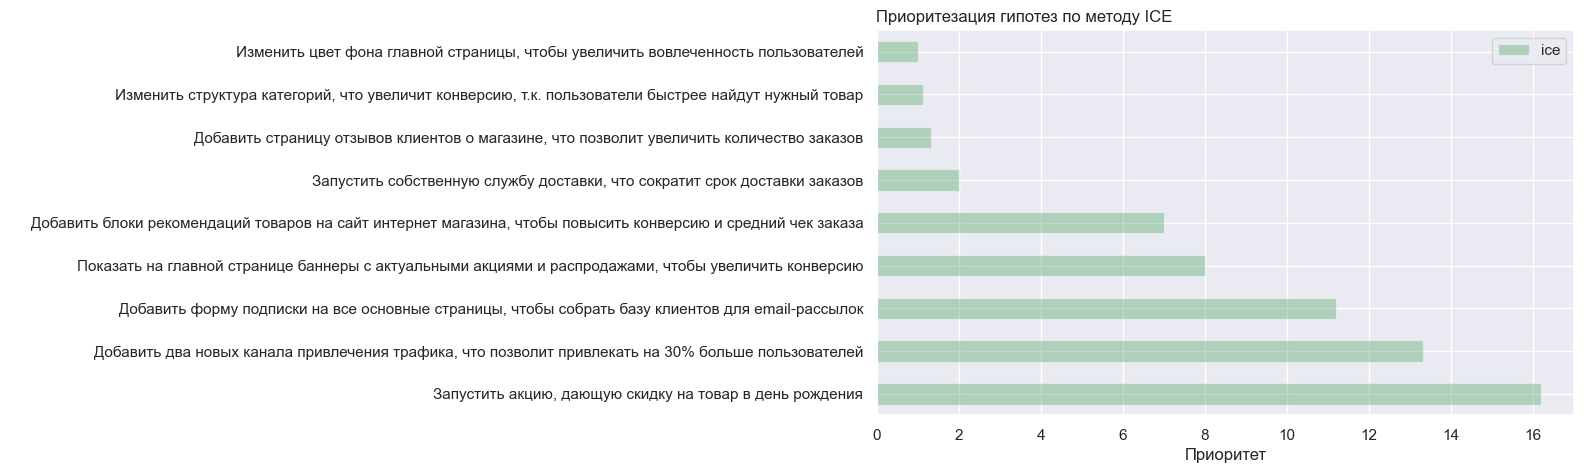

In [11]:
ax = (hypothesis[['hypothesis', 'ice']]
      .set_index('hypothesis')
      .sort_values('ice', ascending=False)
      .plot(kind='barh', color='g', alpha=0.4)
     )
ax.grid(True)
ax.set_xlabel('Приоритет')
ax.set_ylabel(' ')
ax.set_title('Приоритезация гипотез по методу ICE', loc='left')
plt.show()

Итак, мы видим топ-5 гипотез, которым следует уделить пристальное внимание. Добавим к расчету параметр Reach (англ.: Охват) и приоритезируем гипотезы по методу RICE.

In [12]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False).head(5)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200


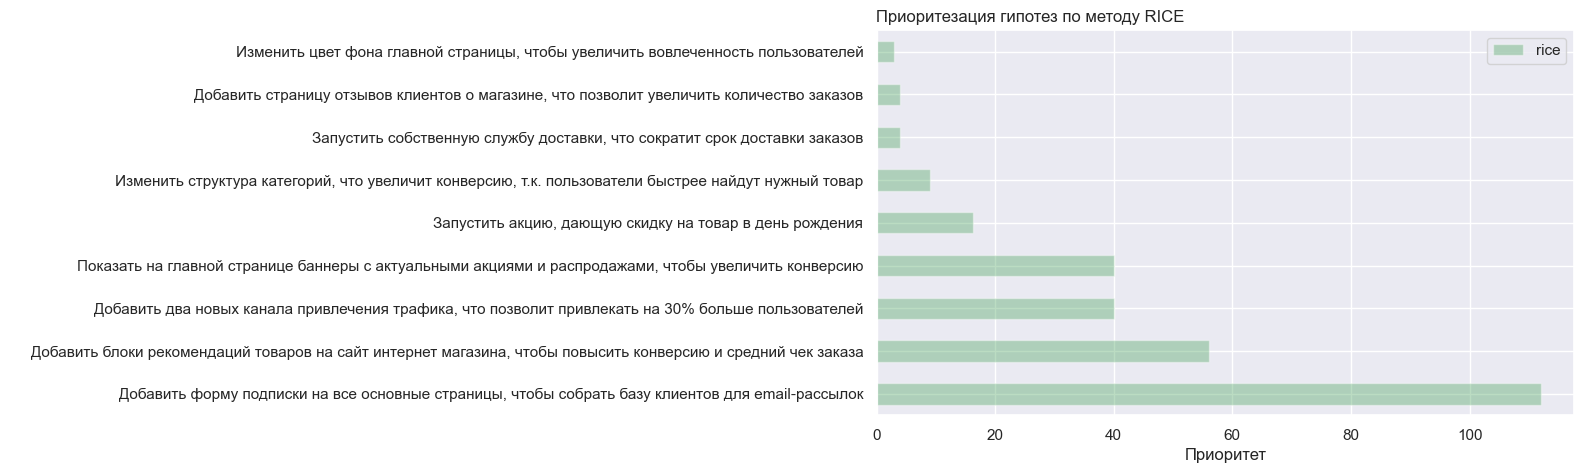

In [13]:
ax = (hypothesis[['hypothesis', 'rice']]
      .set_index('hypothesis')
      .sort_values('rice', ascending=False)
      .plot(kind='barh', color='g', alpha=0.4)
     )
ax.grid(True)
ax.set_xlabel('Приоритет')
ax.set_ylabel(' ')
ax.set_title('Приоритезация гипотез по методу RICE', loc='left')
plt.show()

Мы видим те же самые гипотезы, только в другой последовательности. Разница приоритезиций заключается в том, что одна учитывает кол-во пользователей, которых затронут изменения, а другая - нет.

In [14]:
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False).head(5)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200,16.200


## Анализ A/B-теста

### Кумулятивные метрики

Чтобы построить графики по кумулятивным (накапливаемым) данным, необходимо собрать соответствующий агрегированный датафрейм, содержащий информацию о дате, группе (А или В), кумулятивных количестве заказов и пользователей их оформивших, среднем чеке и, наконец, о кумулятивном количестве посетителей магазина.

In [15]:
# создаем массив уникальных пар значений дат и групп теста
dates_grouped = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head(6)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996


In [16]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head(6)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
310,2019-08-03,B,1803


In [17]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Добавим расчетную колонку с конверсией.

In [18]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head(6)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033
1,2019-08-01,B,21,20,101217,713,0.029
2,2019-08-02,A,44,38,242401,1338,0.033
3,2019-08-02,B,45,43,266748,1294,0.035
4,2019-08-03,A,68,62,354874,1845,0.037
5,2019-08-03,B,61,59,380996,1803,0.034


#### выручка по группам

Построим график кумулятивной выручки по группам.

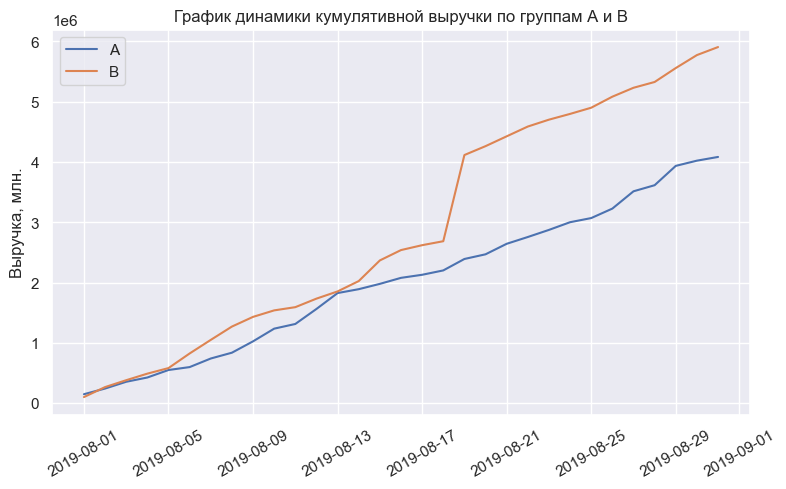

In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Мы видим, что кумулятивная выручка группы А растет линейно,  и она меньше, чем у группы В.    
При этом в группе В есть резкий скачок в районе 18-го августа, что может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

#### средний чек по группам

Построим график динамики кумулятивного среднего чека по группам.

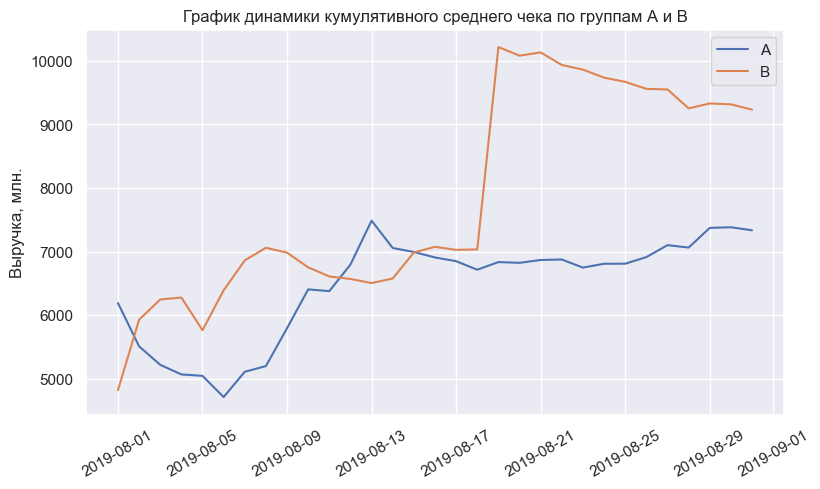

In [20]:
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
         label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Мы видим, что средний чек в группе А  через какое-то время стабилизировался. Средний чек группы В показал резкий рывок, что говорит в пользу версии о дорогой покупке.

#### относительноe изменениe кумулятивного среднего чека группы B к группе A

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

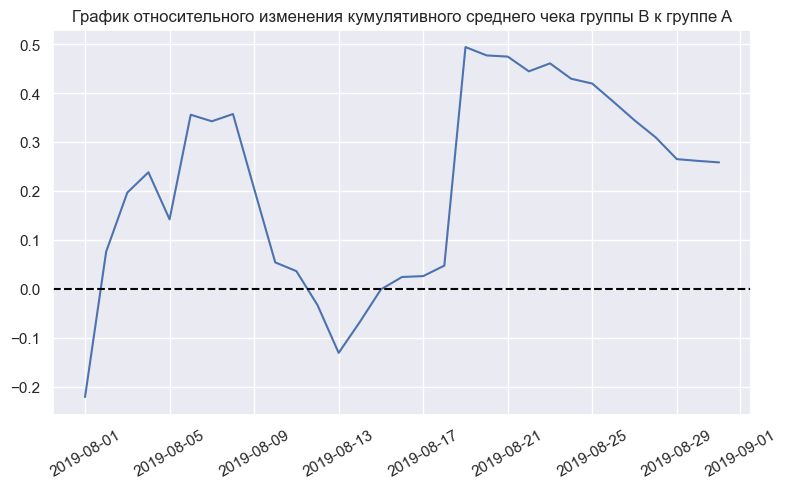

In [21]:
# собираем данные в одном датафрейме
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# cтроим отношение средних чеков
plt.plot(cumulative_revenue_ab['date'], 
         (
             cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b']
         )/
         (
             cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a']
         )-1
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=30)
plt.show()


График резко скачет в нескольких точках - определённо, имеют место какие-то выбросы и крупные заказы.

#### кумулятивная конверсия по группам

Аналогично проанализируем график кумулятивной конверсии по группам А и В.

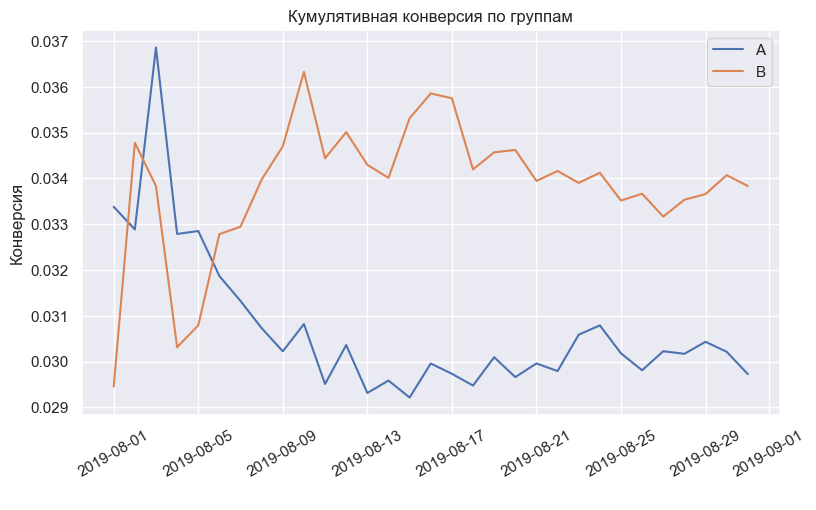

In [22]:
# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('Кумулятивная конверсия по группам')
plt.xlabel(' ')
plt.ylabel('Конверсия')
plt.xticks(rotation=30)
plt.show()

Сначала конверсии колебались, но довольно быстро выровнялись; результат группы В кажется более привлекательным.

#### относительное изменение кумулятивной конверсии группы B к группе A

Построим график относительного различия кумулятивных конверсий.

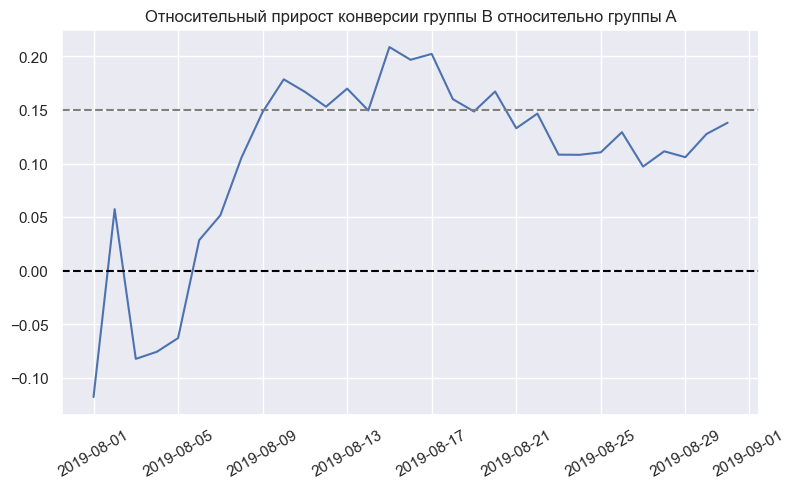

In [23]:
cumulative_conversions_ab = (
    cumulative_data_a[['date','conversion']]
    .merge(
        cumulative_data_b[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)
plt.plot(
    cumulative_conversions_ab['date'], 
    cumulative_conversions_ab['conversion_b']/
    cumulative_conversions_ab['conversion_a']-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xticks(rotation=30)
plt.show()

В начале теста группа В проигрывала группе А, но затем вырвалась вперед. Ее конверсия стремительно росла, далее начался медленный спад. Теперь конверсия группы В снова растет.   
Но мы помним, что графики выше сигнализировали нам о наличии крупных заказов.   
Необходимо проанализировать данные после чистки от выбросов еще раз.


### Анализ количества заказов по пользователям и их стоимости

#### количество заказов по пользователям

Пользователи, совершившие много заказов влияют на числитель формулы конверсии (отношение количества заказов к количеству поситителей интернет-магазина за время теста).    

"Обычный" пользователь редко совершает более одного-двух заказов в короткий срок (если только речь не идет о сайтах с регулярным спросом (например, продуктовый интернет-магазин)). Посмотрим, что с количеством заказов происходит с участниками нашего тестирования.

count   1,031.000
mean        1.161
std         0.725
min         1.000
25%         1.000
50%         1.000
75%         1.000
max        11.000
Name: orders, dtype: float64

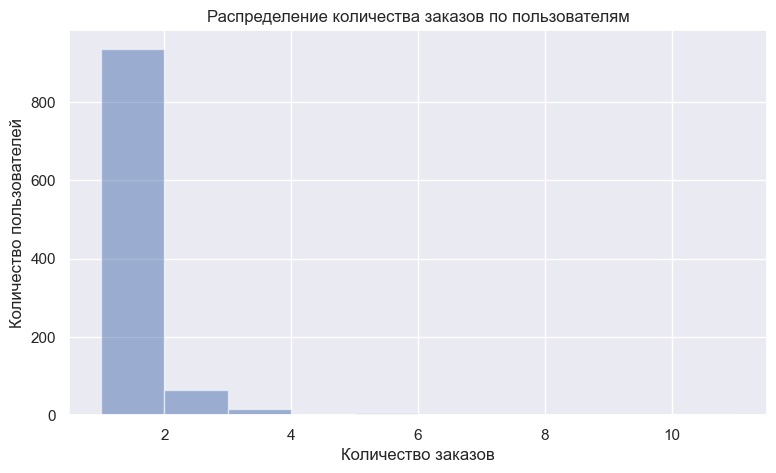

In [24]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']
display(orders_by_users['orders'].describe())

# строим гистограмму
plt.hist(orders_by_users['orders'], alpha=0.5) 
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

Большинство пользователей оформляли заказ один раз, но есть и те, кто успел сделать за месяц одиннадцать заказов.

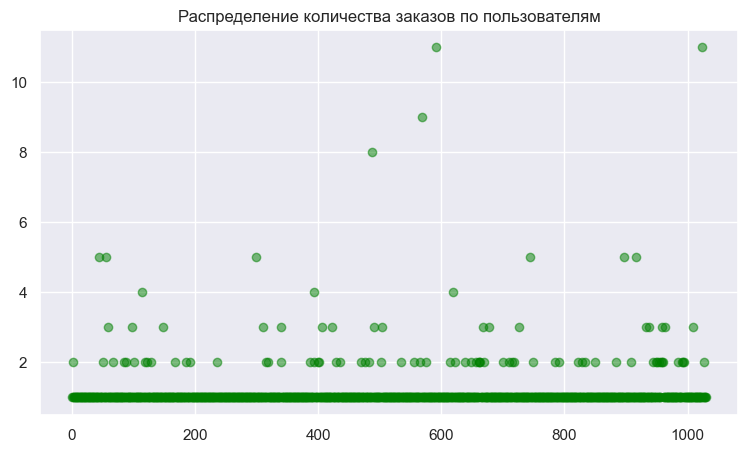

In [25]:
x_values = pd.Series(range(0,len(orders_by_users)))

# строим точечную диаграмму
plt.scatter(x_values, orders_by_users['orders'], color='green', alpha=0.5)
plt.title('Распределение количества заказов по пользователям')
plt.show()

Много пользователей с 2-3 заказами. Их точная доля не ясна, поэтому сложно понять, можно ли считать их выбросами или нет.    
Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [26]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше 2-х покупок в течение тестирования. И только 1% - четыре и более.   
Примем за верхнюю границу **4 заказа** на одного пользователя.

#### стоимость заказов пользователей

Изучим гистограмму стоимости заказов.

count       1,197.000
mean        8,348.006
std        39,191.132
min            50.000
25%         1,220.000
50%         2,978.000
75%         8,290.000
max     1,294,500.000
Name: revenue, dtype: float64

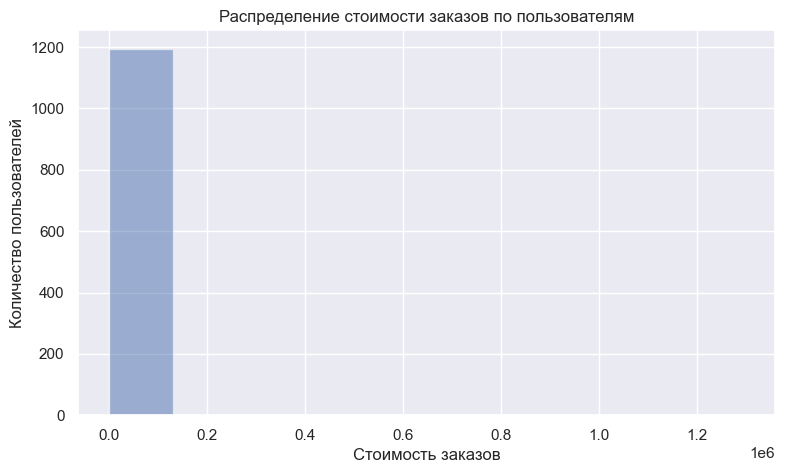

In [27]:
display(orders['revenue'].describe())

# строим гистограмму
plt.hist(orders['revenue'], alpha=0.5) 
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.show()

Один из заказов - почти 1.3 млн.!

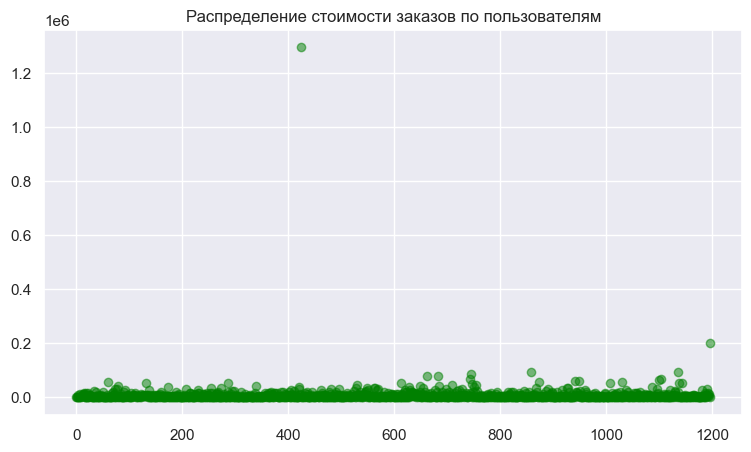

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# строим точечную диаграмму
plt.scatter(x_values, orders['revenue'], color='green', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

Опять мы видим этот гигантский заказ, который вызвал всплеск на графиках кумулятивных метрик, а так же другие весомые заказы, которые могут повлиять на результат исследований.   

Пострим аналогичный график без двух крупных выбросов, которые заметили выше.

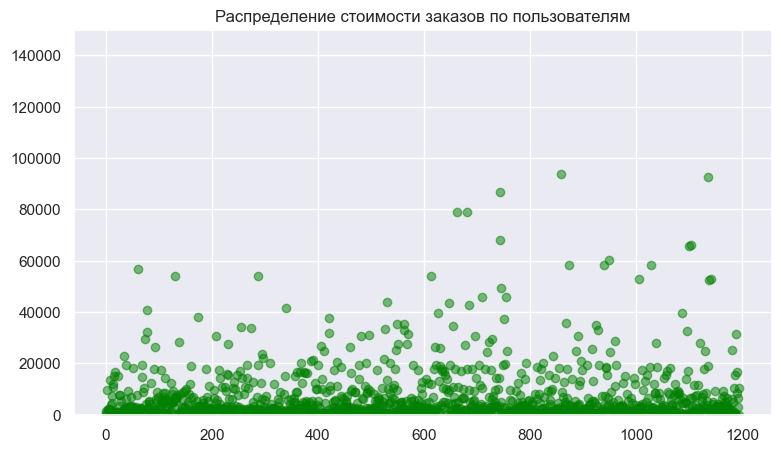

In [29]:
# строим точечную диаграмму
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'], color='green', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

Мы видим, что основная масса заказов не привышает 20000.

Посчитаем 95-й и 99-й перцентили стоимости заказов на пользователя и выберим границу для определения аномалий.

In [30]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Определяем границу по величине 99% перцентиля (**58233**)

### Анализ статистической значимости

####  статистическая значимость различий в конверсии между группами, «сырые» данные

Ранее мы результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть выбросы. Потом увидели выбросы и нашли границу для их определения.

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в конверсии между группами нет}\\
   H_1 :\text{различия в конверсии между группами есть}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 



Начнём с подготовки данных.


Так как данные о продажах и средних чеках редко бывают нормально распределены (это классический пример переменных, подверженных выбросам), для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни.   
Для уровеня значимости установим стандартный уровень статистической значимости, равный 0.05.

In [31]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)

data.head(6)

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935


 Итак, у нас получилсь следующая таблица.

`date` — дата;   
`orders_daily_a` — количество заказов в выбранную дату в группе A;   
`revenue_per_date_a` — суммарная выручка в выбранную дату в группе A;   
`orders_daily_a` — количество заказов в выбранную дату в группе B;   
`revenue_per_date_a` — суммарная выручка в выбранную дату в группе B;   
`orders_cummulative_a` — суммарное число заказов до выбранной даты включительно в группе A;   
`revenue_cummulative_a` — суммарная выручка до выбранной даты включительно в группе A;   
`orders_cummulative_b` — суммарное количество заказов до выбранной даты включительно в группе B;   
`revenue_cummulative_b` — суммарная выручка до выбранной даты включительно в группе B;   
`visitors_per_date_a` — количество пользователей в выбранную дату в группе A;   
`visitors_per_date_b` — количество пользователей в выбранную дату в группе B;   
`visitors_cummulative_a` — количество пользователей до выбранной даты включительно в группе A;     
`visitors_cummulative_b` — количество пользователей до выбранной даты включительно в группе B.    


Создадим переменные orders_by_users_a и orders_by_users_a; в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [32]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [33]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0
                    )

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0
                    )


Задаем функцию, в которой:
- задаем уровень значимости alpha=0.05,   
- применим критерий Манна-Уитни,   
- отформатируем p-value, округлив его до трёх знаков после запятой,    
- выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1, округлив до трёх знаков после запятой.

In [34]:
# Функция для проверки гипотезы о равенстве групп data A и data B
def stat_significance(data_a, data_b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
    print("Относительный прирост В к А: {0:.3%}".format(data_b.mean() / data_a.mean()-1))

In [35]:
stat_significance(sample_a, sample_b)

P-value: 0.017
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 13.808%


По неочищенным данным различия в конверсии между группами есть.   
P-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш группы B равен 13.81%.


#### статистическая значимость различий в среднем чеке заказа между группами, «сырые» данные

Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{различий в среднем чеке между группами нет}\\
   H_1 :\text{различия в среднем чеке между группами есть}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
А ещё найдём относительные различия в среднем чеке между группами.

In [36]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.871%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

#### статистическая значимость различий в конверсии между группами, «очищенные» данные

Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 58233. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — `users_with_many_orders` и пользователей, совершивших заказы дороже 58233 — `users_with_expensive_orders`. Объединим их в таблице `abnormal_users`.     
Узнаем, сколько всего аномальных пользователей методом shape().

In [37]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)


users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

Всего 15 аномальных пользователей.    
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [38]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [39]:
stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.014
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 15.331%


На очищенных данных разница в конверсии между группами есть,  а относительный прирост конверсии группы В отнистельно группы А увеличился на 15.3%. 

####  статистическая значимость различий в среднем чеке заказа между группами, «очищенные» данные

Подсчитаем статистическую значимость различий в среднем чеке после удаления аномальных пользователей.

In [40]:
stat_significance(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
                  )

P-value: 0.851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.575%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. По разнице средних чеков групп различий практически нет.

## Выводы

На основании входных данных, предоставленных интернет-магазином был проведено исследование и вынесены рекомендации, изложенные ниже.
    
**1. В части приоритизации гипотез из списка, предоставленных отделом Маркетинга следует в первую очередь обратить внимание на гипотезы:**   
- "Запустить акцию, дающую скидку на товар в день рождения",   
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",   
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";      

Если ранжирование гипотез должно включать в себя и охват пользователей интернет-магазина, то места необходимо распределить таким образом:   
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",    
- "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",   
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей". 	


**2. В части анализа А/В теста:**   

* Есть статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий. Конверсия группы В выше, чем в А, на 14-15%;    

* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом средний чек группы В выше (на "очищенных" данных  -  на ~2%);   

* График относительного изменения кумулятивной конверсии группы B к группе A показывает, что результаты группы В стабильно лучше группы А;

На основании вышеизложенного рекомендуем остановить тест, зафиксировав победу группы B (ее конверсия значительно  выше конверсии группы А). 